In [1]:
import pandas as pd
import spacy
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet(path='dataset/youtube-agg-nlp-v1.parquet', engine='pyarrow')
df.head()

,AUTHOR,CONTENT,CLASS,IS_YOUTUBE,IS_URL,CONTENT_EDITED,CONTENT_EDITED_TEMP,AUTHOR_SPAM_PROB
0,Julius NM,"Huh, anyway check out this you[tube] channel: ...",1,False,False,huh check tube channel,huh check tube channel,1.0
1,adam riyati,Hey guys check out my new channel and our firs...,1,False,False,hey guy check new channel vid monkey monkey wh...,hey guy check new channel vid monkey monkey wh...,1.0
2,Evgeny Murashkin,just for test I have to say murdev.com,1,False,True,test com,test com,1.0
3,ElNino Melendez,me shaking my sexy ass on my channel enjoy ^_^,1,False,False,shake sexy ass channel enjoy joyful,shake sexy ass channel enjoy joyful,1.0
4,GsMega,watch?v=vtaRGgvGtWQ Check this out .,1,True,False,watch check,watch check,1.0


In [3]:
nlp = spacy.load("en_core_web_md", disable=['parser', 'ner'])
print(nlp.pipe_names)

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']


In [4]:
# create word and document vector of all Contents
docs = list(nlp.pipe(df['CONTENT_EDITED']))
print(docs[0])
print(docs[0].vector.shape)
print(docs[0][0])
print(docs[0][0].vector.shape)
# to show that the document vector is the average of words vector
s = 0
for doc in docs[0]:
    s += doc.vector
assert np.allclose(s / len(docs[0]), docs[0].vector)

huh check tube channel
(300,)
huh
(300,)


First we can use ExtraTreesClassifier and average vector of each document to classify spam, non-spam items.

In [5]:
avg_vect = []
for doc in docs:
    avg_vect.append(doc.vector)
avg_vect = np.array(avg_vect)
target = df['CLASS'].values
print(avg_vect.shape)
print(target.shape)

(1953, 300)
(1953,)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(avg_vect, target, test_size=0.05, random_state=42)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1855, 300) (1855,)
(98, 300) (98,)


In [7]:
clf = ExtraTreesClassifier(n_estimators=100)
print(clf)

ExtraTreesClassifier()


In [8]:
clf.fit(x_train, y_train)
score = clf.score(x_train, y_train)
print(f"Score: {score}")

Score: 0.9973045822102425


In [9]:
cv_scores = cross_val_score(clf, x_train, y_train, cv=5)
print(f"CV average score: {cv_scores.mean():0.2f}")

CV average score: 0.91


[[34  1]
 [ 7 56]]


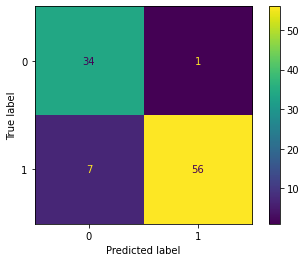

In [10]:
y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

Let's increase the number of trees, and check the change in results. Number of False Negative are higher than False Positive.

Score: 0.9973045822102425
CV average score: 0.92
[[34  1]
 [ 4 59]]


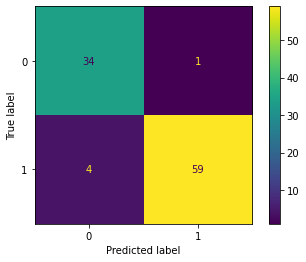

In [11]:
clf = ExtraTreesClassifier(n_estimators=250)
clf.fit(x_train, y_train)
score = clf.score(x_train, y_train)
print(f"Score: {score}")
cv_scores = cross_val_score(clf, x_train, y_train, cv=5)
print(f"CV average score: {cv_scores.mean():0.2f}")
y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

Let's decrease the number of estimators and check the results.

Score: 0.9973045822102425
CV average score: 0.91
[[34  1]
 [ 4 59]]


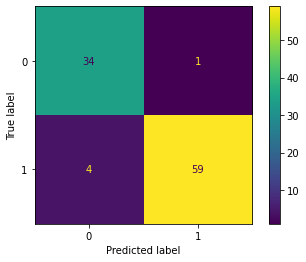

In [12]:
clf = ExtraTreesClassifier(n_estimators=50)
clf.fit(x_train, y_train)
score = clf.score(x_train, y_train)
print(f"Score: {score}")
cv_scores = cross_val_score(clf, x_train, y_train, cv=5)
print(f"CV average score: {cv_scores.mean():0.2f}")
y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

100 estimator seems a good hyperparameter for this classifier.

In [13]:
tfidf_vectorizer = TfidfVectorizer()
transformed_documents = tfidf_vectorizer.fit_transform(df['CONTENT_EDITED'])
max_idf = max(tfidf_vectorizer.idf_)
word2weight = defaultdict(lambda: max_idf,
                          [(w, tfidf_vectorizer.idf_[i]) for w, i in tfidf_vectorizer.vocabulary_.items()])
avg_vect_tfidf = []
for doc in docs:
    doc_vect = np.zeros(docs[0].vector.shape)
    for d in doc:
        doc_vect += word2weight[d] * d.vector
    doc_vect /= (len(doc) + 1)
    avg_vect_tfidf.append(doc_vect)
avg_vect_tfidf = np.array(avg_vect_tfidf)
target = df['CLASS'].values
print(avg_vect_tfidf.shape)
print(target.shape)

(1953, 300)
(1953,)


Score: 0.997843665768194
CV average score: 0.92
[[34  1]
 [ 5 58]]


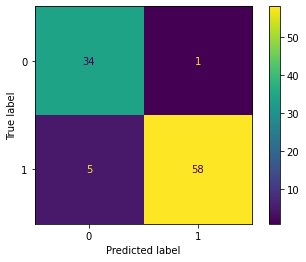

In [14]:
x_train, x_test, y_train, y_test = train_test_split(avg_vect_tfidf, target, test_size=0.05, random_state=42)
clf = ExtraTreesClassifier(n_estimators=250)
clf.fit(x_train, y_train)
score = clf.score(x_train, y_train)
print(f"Score: {score}")
cv_scores = cross_val_score(clf, x_train, y_train, cv=5)
print(f"CV average score: {cv_scores.mean():0.2f}")
y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

Score: 0.9363881401617251
CV average score: 0.90
[[33  2]
 [ 4 59]]


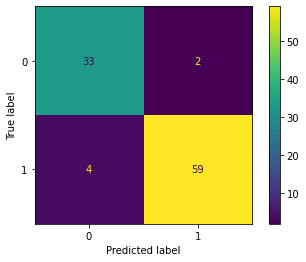

In [22]:
clf = LogisticRegression(max_iter=750)
x_train, x_test, y_train, y_test = train_test_split(avg_vect, target, test_size=0.05, random_state=42)
clf.fit(x_train, y_train)
score = clf.score(x_train, y_train)
print(f"Score: {score}")
cv_scores = cross_val_score(clf, x_train, y_train, cv=5)
print(f"CV average score: {cv_scores.mean():0.2f}")
y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

Score: 0.9671159029649595
CV average score: 0.90
[[32  3]
 [ 7 56]]


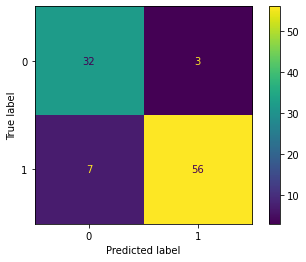

In [24]:
clf = LogisticRegression(max_iter=750)
x_train, x_test, y_train, y_test = train_test_split(avg_vect_tfidf, target, test_size=0.05, random_state=42)
clf.fit(x_train, y_train)
score = clf.score(x_train, y_train)
print(f"Score: {score}")
cv_scores = cross_val_score(clf, x_train, y_train, cv=5)
print(f"CV average score: {cv_scores.mean():0.2f}")
y_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()